---
title: "Predicting covid cases with LSTM Machine Learning Model"
date: 2020-03-20
tags: ["data science", "machine learning", "hugo"]
draft: false
---

In [1]:
# Import various libraries and routines needed for computation
import math 
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.backend as K
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from datetime import date, timedelta, datetime 

In [2]:
df = pd.read_csv('covid_final.csv')  
dataset = df.set_index(['date'])
dataset.drop(dataset.tail(10).index,
        inplace = True)
values = dataset.values

In [3]:
date_index = dataset.index

In [4]:
data_clean = dataset.copy()
data_clean_ext = dataset.copy()
data_clean_ext['new_cases_predictions'] = data_clean_ext['new_cases_smoothed']
data_clean.tail()

,new_cases_smoothed,reproduction_rate,new_tests_smoothed_per_thousand,new_vaccinations_smoothed_per_million,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index
date,,,,,,,
2022-03-08,38934.286,0.65,2.748,621,65.24,28.89,53.24
2022-03-09,36641.429,0.66,2.699,601,65.25,28.91,53.24
2022-03-10,36330.429,0.69,2.613,583,65.27,28.94,53.24
2022-03-11,36104.714,0.71,2.580,557,65.29,28.97,53.24
2022-03-12,35464.143,0.71,2.561,540,65.30,28.99,53.24


In [5]:
# number of rows in the data
nrows = data_clean.shape[0]

In [6]:
# Convert the data to numpy values
np_data_unscaled = np.array(data_clean)
np_data = np.reshape(np_data_unscaled, (nrows, -1))

In [7]:
# ensure all data is float
values = values.astype('float64')

In [8]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

In [9]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_cases = pd.DataFrame(data_clean_ext['new_cases_smoothed'])
np_cases_scaled = scaler_pred.fit_transform(df_cases)

In [10]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 31

# Prediction Index
index_cases = dataset.columns.get_loc("new_cases_smoothed")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_cases]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [11]:

# Configure the neural network model
model = Sequential()
# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
model.add(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [13]:
checkpoint_path = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose =0)
callbacks = [checkpoint, earlystopping]

In [14]:
# Training the model
epochs = 300
batch_size = 20
history = model.fit(x_train, y_train,
                     batch_size=batch_size, 
                     epochs=epochs,
                     validation_data=(x_test, y_test),
                     callbacks = callbacks,
                     verbose = 0)


Epoch 00001: val_loss improved from inf to 0.03988, saving model to my_best_model.hdf5

Epoch 00002: val_loss improved from 0.03988 to 0.03568, saving model to my_best_model.hdf5

Epoch 00003: val_loss did not improve from 0.03568

Epoch 00004: val_loss did not improve from 0.03568

Epoch 00005: val_loss did not improve from 0.03568

Epoch 00006: val_loss did not improve from 0.03568

Epoch 00007: val_loss did not improve from 0.03568

Epoch 00008: val_loss did not improve from 0.03568

Epoch 00009: val_loss did not improve from 0.03568

Epoch 00010: val_loss did not improve from 0.03568

Epoch 00011: val_loss did not improve from 0.03568

Epoch 00012: val_loss did not improve from 0.03568

Epoch 00013: val_loss did not improve from 0.03568

Epoch 00014: val_loss did not improve from 0.03568

Epoch 00015: val_loss did not improve from 0.03568

Epoch 00016: val_loss did not improve from 0.03568

Epoch 00017: val_loss did not improve from 0.03568

Epoch 00018: val_loss did not improve f

In [15]:
from tensorflow.keras.models import load_model
model_from_saved_checkpoint = load_model(checkpoint_path)

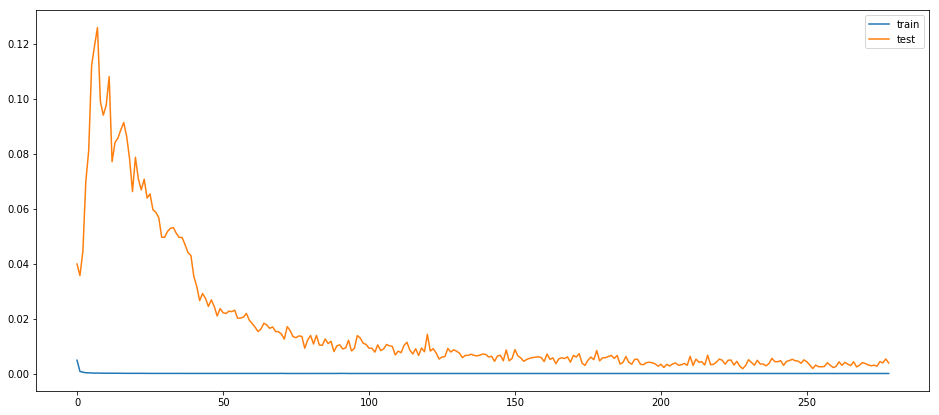

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
# Get the predicted values
y_pred_scaled = model_from_saved_checkpoint.predict(x_test)

In [18]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)

In [19]:
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 26045.48
Mean Absolute Percentage Error (MAPE): 18.19 %
Median Absolute Percentage Error (MDAPE): 14.58 %


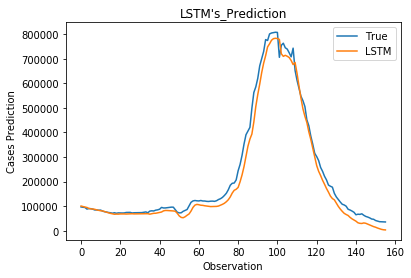

In [21]:
plt.plot(y_test_unscaled, label='True')
plt.plot(y_pred, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('Cases Prediction')
plt.legend()
plt.show()

In [22]:
new_df = data_clean[-sequence_length:]
N = sequence_length

In [23]:
# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

In [24]:
# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_cases_scaled = model_from_saved_checkpoint.predict(np.array(X_test_new))
pred_cases_unscaled = scaler_pred.inverse_transform(pred_cases_scaled.reshape(-1, 1))

In [25]:
# Print last price and predicted price for the next day
cases_today = np.round(new_df['new_cases_smoothed'][-1])
predicted_cases = np.round(pred_cases_unscaled.ravel()[0])
change_percent = np.round(100 - (cases_today * 100)/predicted_cases)

In [28]:
plus = '+'; minus = ''
print(f'The close covid cases count today is  {cases_today}')
print(f'The predicted case count for the next day is {predicted_cases} ({plus if change_percent > 0 else minus}{change_percent}%)')

The close covid cases count today is  35464.0
The predicted case count for the next day is 2843.0 (-1147.0%)


In [27]:
!jupyter nbconvert covid_analysis.ipynb --to markdown --NbConvertApp.output_files_dir=.
!cat covid_analysis.md | tee -a index.md
!rm covid_analysis.md

[NbConvertApp] Converting notebook covid_analysis.ipynb to markdown
---
title: "Predicting covid cases with LSTM Machine Learning Model"
date: 2020-03-20
tags: ["data science", "machine learning", "hugo"]
draft: false
---


```python
# Import various libraries and routines needed for computation
import math 
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.backend as K
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from datetime import date, timedelta, datetime 
```


```python
df = pd.read_csv('covid_final.csv')  
dataset = df.set_index(['date'])